In [1]:
import pickle
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
from cautious_extrapolation.data_paths import DATA_PATHS
from wilds import get_dataset

In [2]:
dataset = get_dataset(dataset="amazon", download=True, root_dir=DATA_PATHS["nfs"]["Amazon"])

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_data = dataset.get_subset(
    "train",
)

train_labels = train_data.dataset._y_array[train_data.indices].numpy()  
class_probs = [np.mean(train_labels == i) for i in range(5)]
print(class_probs)
class_probs = np.array(class_probs)
f_star = class_probs*1+(1-class_probs)*-4
f_star = np.append(f_star, 0)

[0.010786062842665234, 0.027474317928163516, 0.09329048235859586, 0.2930688955690789, 0.5753802413014966]


In [4]:
ood_data = dataset.get_subset(
    "val",
)
ood_labels = train_data.dataset._y_array[ood_data.indices].numpy()  

In [5]:
with open('data/reward_prediction_seed0_2023_06_07_19_01_32/outputs.pkl', 'rb') as f:
    data = pickle.load(f)

In [6]:
#subsample for incorrect predictions and reweight based on class probs to match train distribution class probs
wrong_idxs = np.where(data[1][:, :-1].argmax(axis=1)!=ood_labels)[0]
subsampled_idxs = []
for c in range(5):
    num_points = int(class_probs[c]*len(wrong_idxs))
    subsampled_idxs.append(wrong_idxs[np.random.choice(np.where(ood_labels[wrong_idxs] == c)[0], num_points, replace=True)])
subsampled_idxs = np.concatenate(subsampled_idxs)
np.save("data/ood1_subsampled_idxs.npy", subsampled_idxs)
print([np.mean(ood_labels[subsampled_idxs] == i) for i in range(5)])

[0.010760506034608115, 0.027446561000436236, 0.09328195434055547, 0.2930783771993602, 0.5754326014250399]


In [7]:
#load pickle
with open("data/ood_classifier_seed0_2023_07_12_23_19_58/outputs.pkl", 'rb') as f:
    outputs = pickle.load(f)
ood_classification = softmax(outputs[1], axis=1)

with open("data/ood_classifier_seed1_2023_07_12_23_13_42/outputs.pkl", 'rb') as f:
    outputs = pickle.load(f)
ood_classification2 = softmax(outputs[1], axis=1)

ood_ood_score = np.mean([np.mean(ood_classification[:, 1]), np.mean(ood_classification2[:, 1])])

In [17]:
run_names = ["reward_prediction_seed0_2023_06_07_19_01_32", "reward_prediction_seed1_2023_06_08_23_50_15", "reward_prediction_seed2_2023_06_08_23_50_35", "reward_prediction_seed3_2023_06_08_23_50_55", "reward_prediction_seed4_2023_06_08_23_59_43"]

ood_dist_to_f_star = []
val_dist_to_f_star = []

for run_name in run_names:
    with open('data/'+run_name+'/outputs.pkl', 'rb') as f:
        data = pickle.load(f)
        ood_dist_to_f_star.append(np.mean((data[1][subsampled_idxs] - np.expand_dims(f_star, axis=0))**2))
        val_dist_to_f_star.append(np.mean((data[0] - np.expand_dims(f_star, axis=0))**2))


/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  


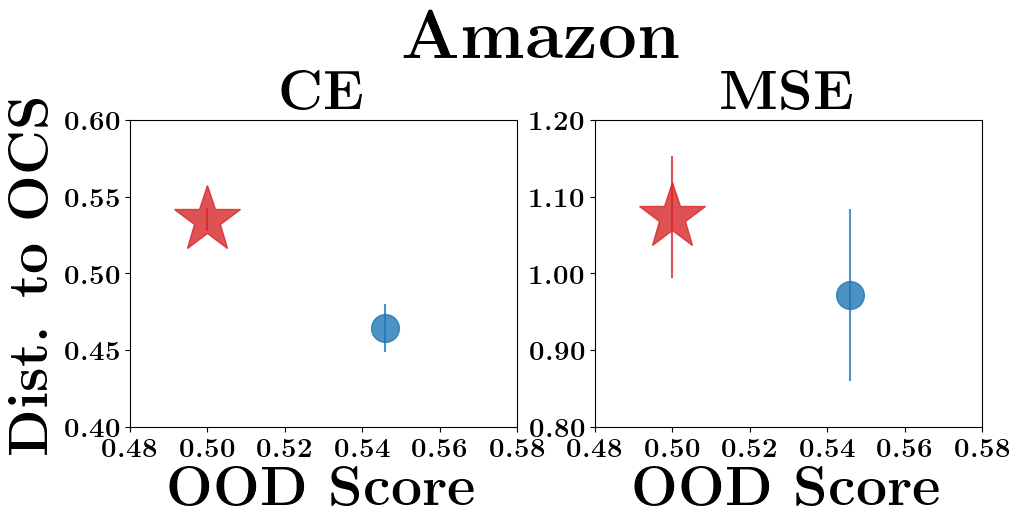

In [18]:
import matplotlib as mpl
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

colors=["C3", "C0", "C1", "C2", "C4", "C5", "C6", "C7", "C8", "C9"]

fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(5.5*2, 4.8))#, gridspec_kw={'width_ratios': [1, 1.5]})



ax1.errorbar([0.5], [np.mean(val_dist_to_f_star)], yerr=[np.std(val_dist_to_f_star)], fmt='*', markersize=50, zorder=100, alpha=0.8, color=colors[0])
ax1.errorbar([ood_ood_score], [np.mean(ood_dist_to_f_star)], yerr=[np.std(ood_dist_to_f_star)], fmt='o', markersize=20, alpha=0.8, color=colors[1])

ax1.set_xlabel(r"\textbf{OOD Score}", fontsize=40)

# ax1.set_ylabel(r"\textbf{Dist. to OCS}", fontsize=40)
ax1.set_title(r"\textbf{MSE}", fontsize=40)
# ytick_labels = [r"\textbf{"+str(0.1)+"}", r"\textbf{"+str(0.15)+"}", r"\textbf{"+str(0.2)+"}", r"\textbf{"+str(0.25)+"}", r"\textbf{"+str(0.3)+"}"]
ax1.set_yticks([0.8+_*0.1 for _ in range(10)], [r"\textbf{%.2f}"%(0.8+_*0.1) for _ in range(10)], fontsize=20)
xticks_labels = [r"\textbf{%.2f}"%(0.48+0.02*_) for _ in range(6)]
ax1.set_xticks([0.48+0.02*_ for _ in range(6)], xticks_labels, fontsize=20)
ax1.set_ylim([0.8, 1.2])
ax1.set_xlim([0.48, 0.58])


run_names2 = ["xent_seed0_2023_06_21_04_02_54", "xent_seed1_2023_06_21_13_55_05", "xent_seed2_2023_06_21_23_47_33", "xent_seed3_2023_06_22_09_40_58", "xent_seed4_2023_06_22_19_33_20"]
ood_dist_to_f_star = []
val_dist_to_f_star = []

for run_name in run_names2:
    with open('data/'+run_name+'/outputs.pkl', 'rb') as f:
        data = pickle.load(f)
        dist  = softmax(data[1][subsampled_idxs], axis=-1)
        ood_dist_to_f_star.append(np.sum(dist*np.log(dist/np.expand_dims(class_probs, axis=0)), axis=-1).mean())
        dist  = softmax(data[0], axis=-1)
        val_dist_to_f_star.append(np.sum(dist*np.log(dist/np.expand_dims(class_probs, axis=0)), axis=-1).mean())


ax2.errorbar([0.5], [np.mean(val_dist_to_f_star)], yerr=[np.std(val_dist_to_f_star)], fmt='*', markersize=50, zorder=100, alpha=0.8, color=colors[0])
ax2.errorbar([ood_ood_score], [np.mean(ood_dist_to_f_star)], yerr=[np.std(ood_dist_to_f_star)], fmt='o', markersize=20, alpha=0.8, color=colors[1])

ax2.set_xlabel(r"\textbf{OOD Score}", fontsize=40)

ax2.set_ylabel(r"\textbf{Dist. to OCS}", fontsize=40)
ax2.set_title(r"\textbf{CE}", fontsize=40)
# ytick_labels = [r"\textbf{"+str(0.1)+"}", r"\textbf{"+str(0.15)+"}", r"\textbf{"+str(0.2)+"}", r"\textbf{"+str(0.25)+"}", r"\textbf{"+str(0.3)+"}"]
ax2.set_yticks([0.4+_*0.05 for _ in range(10)], [r"\textbf{%.2f}"%(0.4+_*0.05) for _ in range(10)], fontsize=20)
xticks_labels = [r"\textbf{%.2f}"%(0.48+0.02*_) for _ in range(6)]
ax2.set_xticks([0.48+0.02*_ for _ in range(6)], xticks_labels, fontsize=20)
ax2.set_ylim([0.4, 0.6])
ax2.set_xlim([0.48, 0.58])


# set title to both subplots
fig.suptitle(r"\textbf{Amazon}", fontsize=50)
# fig.tight_layout()
fig.subplots_adjust(top=0.75)

plt.show()

In [19]:
# import matplotlib as mpl
# from matplotlib import rc 

# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)
# mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

# colors=["C3", "C0", "C1", "C2", "C4", "C5", "C6", "C7", "C8", "C9"]

# plt.rcParams["figure.figsize"] = np.array([6.4, 4.8])/4*3.5
# plt.figure()
# ax = plt.gca()

# plt.errorbar([0.5], [np.mean(val_dist_to_f_star)], yerr=[np.std(val_dist_to_f_star)], fmt='*', markersize=50, zorder=100, alpha=0.8, color=colors[0])
# plt.errorbar([ood_ood_score], [np.mean(ood_dist_to_f_star)], yerr=[np.std(ood_dist_to_f_star)], fmt='o', markersize=20, alpha=0.8, color=colors[1])


# plt.xlabel(r"\textbf{OOD Score}", fontsize=40)
# plt.ylabel(r"\textbf{Dist. to OCS}", fontsize=40)
# plt.title(r"\textbf{Amazon (MSE)}", fontsize=40)
# plt.yticks([0.8+_*0.1 for _ in range(10)], [r"\textbf{%.2f}"%(0.8+_*0.1) for _ in range(10)], fontsize=20)
# xticks_labels = [r"\textbf{%.2f}"%(0.48+0.02*_) for _ in range(6)]
# plt.xticks([0.48+0.02*_ for _ in range(6)], xticks_labels, fontsize=20)
# plt.ylim([0.8, 1.2])
# plt.xlim([0.48, 0.58])

In [20]:
# run_names2 = ["xent_seed0_2023_06_21_04_02_54", "xent_seed1_2023_06_21_13_55_05", "xent_seed2_2023_06_21_23_47_33", "xent_seed3_2023_06_22_09_40_58", "xent_seed4_2023_06_22_19_33_20"]
# ood_dist_to_f_star = []
# val_dist_to_f_star = []

# for run_name in run_names2:
#     with open('data/'+run_name+'/outputs.pkl', 'rb') as f:
#         data = pickle.load(f)
#         dist  = softmax(data[1][subsampled_idxs], axis=-1)
#         ood_dist_to_f_star.append(np.sum(dist*np.log(dist/np.expand_dims(class_probs, axis=0)), axis=-1).mean())
#         dist  = softmax(data[0], axis=-1)
#         val_dist_to_f_star.append(np.sum(dist*np.log(dist/np.expand_dims(class_probs, axis=0)), axis=-1).mean())

In [21]:
# import matplotlib as mpl
# from matplotlib import rc

# plt.rcParams.update(plt.rcParamsDefault)

# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)
# mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

# colors=["C3", "C0", "C1", "C2", "C4", "C5", "C6", "C7", "C8", "C9"]

# plt.figure()
# ax = plt.gca()

# plt.errorbar([0.5], [np.mean(val_dist_to_f_star)], yerr=[np.std(val_dist_to_f_star)], fmt='*', markersize=50, zorder=100, alpha=0.8, color=colors[0])
# plt.errorbar([ood_ood_score], [np.mean(ood_dist_to_f_star)], yerr=[np.std(ood_dist_to_f_star)], fmt='o', markersize=20, alpha=0.8, color=colors[1])


# plt.xlabel(r"\textbf{OOD Score}", fontsize=40)
# plt.ylabel(r"\textbf{Dist. to OCS}", fontsize=40)
# plt.title(r"\textbf{Amazon (CE)}", fontsize=40)
# plt.yticks([0.44+_*0.02 for _ in range(10)], [r"\textbf{%.2f}"%(0.44+_*0.02) for _ in range(10)], fontsize=20)
# xticks_labels = [r"\textbf{%.2f}"%(0.48+0.02*_) for _ in range(6)]
# plt.xticks([0.48+0.02*_ for _ in range(6)], xticks_labels, fontsize=20)
# plt.ylim([0.45, 0.55])
# plt.xlim([0.48, 0.58])
# plt.show()